In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_file(name):
    file = pd.read_csv(name)
    file.set_index("PassengerId",inplace = True)
    file = file.to_numpy().astype(float)
    return file

X_test = load_file("Preprocessed_Data/X_test.csv")
X_train = load_file("Preprocessed_Data/X_train.csv")
y_test = load_file("Preprocessed_Data/y_test.csv")
y_train = load_file("Preprocessed_Data/y_train.csv")
target = load_file("Preprocessed_Data/target.csv")

target_index = pd.read_csv("Preprocessed_Data/target.csv")
target_index = target_index["PassengerId"]

In [35]:
from tensorflow import keras
from keras.layers import Dense, Dropout, Input
from keras import Model, metrics
from keras.regularizers import L1L2,L1,L2

def create_model(lr,rr, X_train, dropout):
    inp = Input(shape=X_train[0].shape)
    
    x = Dense(units = 256, activation = "relu", kernel_regularizer = L1(rr))(inp)
    
    x = Dense(units = 128, activation = "relu", kernel_regularizer = L1(rr))(x)
    
    x = Dropout(rate = dropout)(x)
        
    x = Dense(units = 16, activation = "relu", kernel_regularizer = L1(rr))(x)
        
    x = Dense(units = 1, activation = "sigmoid")(x)
    
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    loss = "binary_crossentropy"

    model = Model(inp,x,name="titanic")
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = [
            "accuracy",
            "AUC"
        ]
    )
    
    return model
    
def train_model(model,x,y,epochs,batch_size,validation_splitpatience):
    history = model.fit(
        x = x,
        y = y,
        epochs = epochs,
        batch_size = batch_size,
        shuffle = True,
        validation_split = validation_split,
    )
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist    
    
def plot_output(epochs,hist,list_of_metrics):
    plt.figure(figsize=(10,5))
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.ylim([0, 1])
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    plt.show()
    
def get_predictions(threshold,model,data):
    predictions = model.predict(data)
    predictions = [1 if x > threshold else 0 for x in predictions]
    return predictions

Epoch 1/100
9/9 [==============================] - 2s 79ms/step - loss: 8.1142 - accuracy: 0.6333 - auc: 0.6628 - val_loss: 7.5767 - val_accuracy: 0.8042 - val_auc: 0.8530
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 7.4546 - accuracy: 0.7468 - auc: 0.8122 - val_loss: 6.9737 - val_accuracy: 0.8042 - val_auc: 0.8645
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 6.8540 - accuracy: 0.7594 - auc: 0.8287 - val_loss: 6.4082 - val_accuracy: 0.7902 - val_auc: 0.8686
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 6.3001 - accuracy: 0.7909 - auc: 0.8348 - val_loss: 5.8764 - val_accuracy: 0.7972 - val_auc: 0.8702
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 5.7663 - accuracy: 0.8083 - auc: 0.8540 - val_loss: 5.3799 - val_accuracy: 0.8042 - val_auc: 0.8714
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 5.2708 - accuracy: 0.7905 - auc: 0.8521 - val_loss: 4.8981 - val_accu

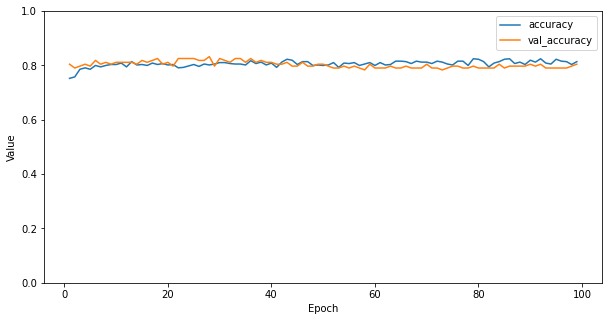

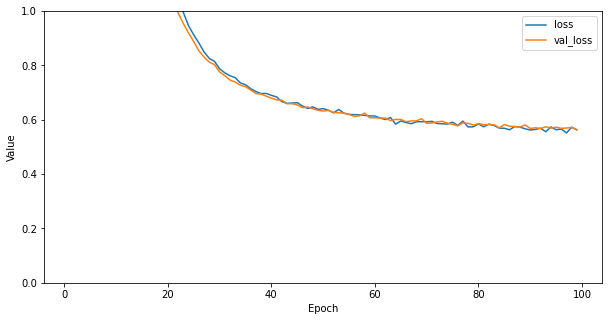

In [36]:
learning_rate =  0.0007
dropout = 0.3
batch_size = 64
epochs = 100
validation_split = 0.2
regularization_rate = 0.003

model = create_model(learning_rate,regularization_rate,X_train,dropout)
epochs, hist = train_model(model,X_train,y_train,epochs,batch_size,validation_split)

plot_output(epochs,hist,["accuracy","val_accuracy"])
plot_output(epochs,hist,["loss","val_loss"])


6/6 [==============================] - 0s 1ms/step - loss: 0.5371 - accuracy: 0.8101 - auc: 0.8399


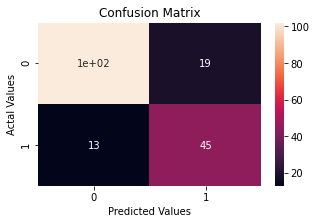

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.evaluate(X_test,y_test)

predictions = get_predictions(0.4,model,X_test)
cm = pd.DataFrame(confusion_matrix(y_test,predictions))
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [38]:
from datetime import datetime

predictions = get_predictions(0.4,model,target)

df = pd.DataFrame(predictions,columns=["Survived"])
df.index = target_index
df.index.name = 'PassengerId'
now = datetime.now()
now = now.strftime("%Y.%m.%d.%H.%M")
# df.to_csv("Predictions/{}.csv".format(now))